# Project Demo

This notebook provides a brief demo of pre-trained models from each of the other model notebooks.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_addons as tfa
import time

from IPython import display

import settransformer as sf

import common

## Configuration

In [2]:
strategy = common.strategy("gpu:0")
# strategy = common.strategy(multi_gpu=True)

In [3]:
NUM_POINTS = 500 # Maximum number of points per set

In [4]:
PLOT_WINDOW = (-3, 3) # Coordinate range in matplotlib plots

---
## AC-GAST

This AC-GAST model allows generating specific MNIST digit point clouds.

### Configuration

First, we ensure that we are using Keras' multi-head attention for the set transformers framework.

In [5]:
sf.config("use_keras_mha", True)

True

Next, we define the model architecture and hyperparameters

In [6]:
NOISE_DIM = 64
EMBED_DIM = 64
LATENT_DIM = EMBED_DIM
NUM_HEADS = 4
NUM_ANCHORS = 24
MAX_SET_SIZE = NUM_POINTS

### Generator

The following cell contains the definition of the AC-GAST generator model.

In [7]:
with strategy.scope():
    # Noise, label, and cardinality input
    noise = keras.layers.Input((LATENT_DIM,))
    label = keras.layers.Input((1,), dtype=tf.float32)
    cardinality = keras.layers.Input((1,), dtype=tf.int32)
    
    # Create conditioning representation
    condition = keras.layers.Embedding(10, LATENT_DIM)(label)
    condition = keras.layers.Flatten()(condition)
    condition = keras.layers.Concatenate()((noise, condition))
    condition = keras.layers.Dense(LATENT_DIM)(condition)
    
    # Sample a random set
    y1 = y = common.SampleSet(NUM_POINTS, EMBED_DIM)(cardinality)
    
    # Condition the set
    y1 = common.ConditionedISAB(embed_dim=EMBED_DIM, dim_cond=LATENT_DIM, num_heads=NUM_HEADS, num_anchors=NUM_ANCHORS)((y, condition))
    y = keras.layers.Add()((y1, y))
    y1 = common.ConditionedISAB(embed_dim=EMBED_DIM, dim_cond=LATENT_DIM, num_heads=NUM_HEADS, num_anchors=NUM_ANCHORS)((y, condition))
    y = keras.layers.Add()((y1, y))
    y1 = common.ConditionedISAB(embed_dim=EMBED_DIM, dim_cond=LATENT_DIM, num_heads=NUM_HEADS, num_anchors=NUM_ANCHORS)((y, condition))
    y = keras.layers.Add()((y1, y))
    y = common.ConditionedISAB(embed_dim=EMBED_DIM, dim_cond=LATENT_DIM, num_heads=NUM_HEADS, num_anchors=NUM_ANCHORS)((y, condition))
    
    y = tfa.layers.SpectralNormalization(keras.layers.Dense(2, use_bias=False))(y)
    generator = keras.Model((noise, label, cardinality), y)

### Discriminator

This next cell constructs the discriminator of the AC-GAST model. This discriminator takes a set as input, and outputs both the probability of the input being a real sample, as well as the class that it belongs to (i.e. digit.

In [8]:
with strategy.scope():
    y = x = keras.layers.Input((None, 2))
    y1 = y = keras.layers.Dense(EMBED_DIM)(y)
    
    # Encode the set
    enc = []
    for i in range(3):
        y = sf.ISAB(EMBED_DIM, num_heads=NUM_HEADS, num_induce=NUM_ANCHORS)(y)
        y1 = y = keras.layers.Add()((y1, y))
        enc.append(sf.ISE(1, LATENT_DIM, NUM_HEADS)(y))

    y = keras.layers.Concatenate()(enc)
    
    valid = keras.layers.Dense(1, activation="sigmoid")(y)
    label = keras.layers.Dense(11, activation="softmax")(y)

    discriminator = keras.Model(x, (valid, label))

### Coupled Model

With the generator and discriminator defined, we now couple the model together as a single Keras model. This allows us to manage the complete model more conveniently.

In [9]:
with strategy.scope():
    noise = keras.layers.Input(generator.input_shape[0][1:])
    label = keras.layers.Input(generator.input_shape[1][1:])
    cardinality = keras.layers.Input(generator.input_shape[2][1:])
    y = generator((noise, label, cardinality))
    y = discriminator(y)
    model = keras.Model((noise, label, cardinality), y)

In [10]:
model.load_weights("./models/acgast.h5")

### Sample Runs

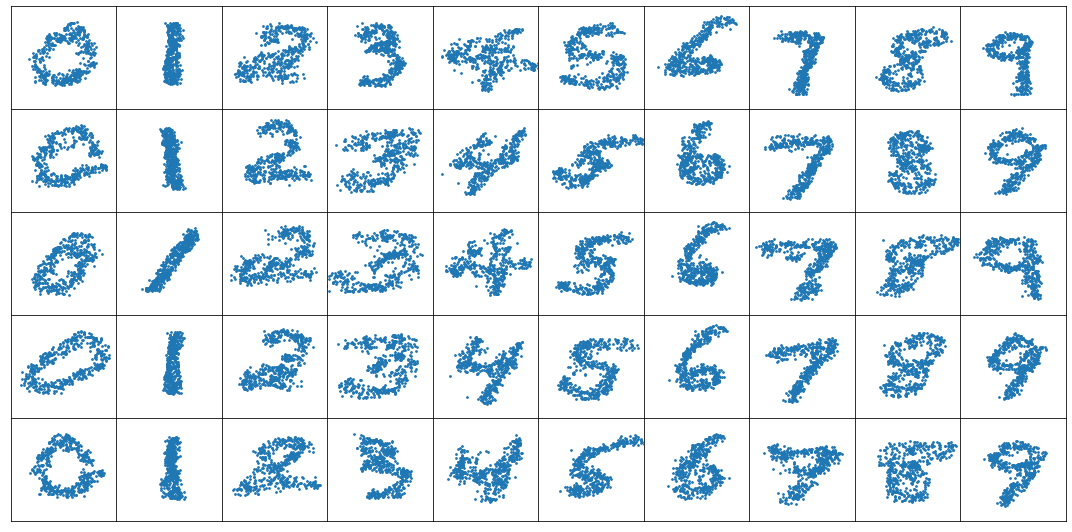

In [11]:
num_samples = 5
num_points = 500
test_noise = tf.random.normal((num_samples*10, LATENT_DIM))
test_labels = tf.tile(tf.range(10), (num_samples,))
test_n = tf.repeat(tf.constant([num_points]), tf.shape(test_noise)[0])

size = (10*1.5, num_samples*1.5)

samples = generator((test_noise, test_labels, test_n))
display.clear_output(wait=True)

plt.figure(figsize=size)
for i in range(num_samples):
    for j in range(10):
        sample_id = 10*i + j
        sample = tf.transpose(samples[sample_id])
        plt.subplot(num_samples, 10, sample_id + 1)
        plt.scatter(*sample, s=3)
        plt.xticks([])
        plt.yticks([])
        plt.xlim(PLOT_WINDOW)
        plt.ylim(PLOT_WINDOW)
plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

---
## Cycle-GAST

This Cycle-GAST model aims to map point clouds of 1s to point clouds of 5s, and vice versa.

### Configuration

We first again ensure that the Set Transformers framework is utilizing Keras' multi-head attention mechanism.

In [12]:
sf.config("use_keras_mha", True)

True

Next, we specify the architecture configuration hyperparameters like so.

In [13]:
NOISE_DIM = 64
EMBED_DIM = 64
LATENT_DIM = 256
NUM_HEADS = 4
NUM_ANCHORS = 24

### Generator Definition

As we need to create a generator for each mapping, we define a function to construct a generator as needed.

In [14]:
def create_generator(name=None):
    
    # Input digit point cloud
    y = x = keras.layers.Input((None, 2))
    
    # Embed digit into permutation-invariant representation
    y1 = y = keras.layers.Dense(EMBED_DIM)(y)
    enc = []
    for _ in range(3):
        y = sf.ISAB(EMBED_DIM, num_heads=NUM_HEADS, num_induce=NUM_ANCHORS)(y)
        y1 = y = keras.layers.Add()((y1, y))
        enc.append(sf.ISE(1, EMBED_DIM, NUM_HEADS)(y))
    y = keras.layers.Concatenate()(enc)
    embed = y = keras.layers.Dense(LATENT_DIM)(y) # The permutation-invariant representation of the digit
    
    # Extract the set cardinality
    cardinality = keras.layers.Lambda(lambda x: tf.repeat(tf.shape(x)[1], tf.shape(x)[0]))(x)
    
    # Sample a random set
    y = common.SampleSet(NUM_POINTS, EMBED_DIM)(cardinality)

    # Condition the set
    y1 = common.ConditionedISAB(embed_dim=EMBED_DIM, dim_cond=LATENT_DIM, num_heads=NUM_HEADS, num_anchors=NUM_ANCHORS)((y, embed))
    y = keras.layers.Add()((y1, y))
    y1 = common.ConditionedISAB(embed_dim=EMBED_DIM, dim_cond=LATENT_DIM, num_heads=NUM_HEADS, num_anchors=NUM_ANCHORS)((y, embed))
    y = keras.layers.Add()((y1, y))
    y1 = common.ConditionedISAB(embed_dim=EMBED_DIM, dim_cond=LATENT_DIM, num_heads=NUM_HEADS, num_anchors=NUM_ANCHORS)((y, embed))
    y = keras.layers.Add()((y1, y))
    y = common.ConditionedISAB(embed_dim=EMBED_DIM, dim_cond=LATENT_DIM, num_heads=NUM_HEADS, num_anchors=NUM_ANCHORS)((y, embed))
    
    # Project to spatial dimension
    y = tfa.layers.SpectralNormalization(keras.layers.Dense(2, use_bias=False))(y)

    return keras.Model(x, y, name=name)

### Discriminator Definition

In the same manner as the generator, we define a function to construct the discriminator.

In [15]:
def create_discriminator(name=None):
    # Input  digit point cloud
    y = x = keras.layers.Input((None, 2))
    y1 = y = keras.layers.Dense(EMBED_DIM)(y)

    # Encode the digit
    enc = []
    for i in range(3):
        y = sf.ISAB(EMBED_DIM, num_heads=NUM_HEADS, num_induce=NUM_ANCHORS)(y)
        y1 = y = keras.layers.Add()((y1, y))
        enc.append(sf.ISE(1, LATENT_DIM, NUM_HEADS)(y))
    y = keras.layers.Concatenate()(enc)
    
    # Predict if the digit is real
    y = tfa.layers.SpectralNormalization(keras.layers.Dense(1, use_bias=False))(y)
    
    return keras.Model(x, y, name=name)

### Model Creation

With the model architecture defined, we can intsantiate the model itself.

In [16]:
with strategy.scope():
    generator_g = create_generator("X_Y")
    generator_f = create_generator("Y_X")

    discriminator_x = create_discriminator("X")
    discriminator_y = create_discriminator("Y")

In [17]:
epoch = 100
generator_f.load_weights(f"./models/cyclegast_gen_f_{epoch}.h5")
generator_g.load_weights(f"./models/cyclegast_gen_g_{epoch}.h5")
discriminator_x.load_weights(f"./models/cyclegast_disc_x_{epoch}.h5")
discriminator_y.load_weights(f"./models/cyclegast_disc_y_{epoch}.h5")

### Dataset

As this model maps an existing set from one domain to another, we need some MNIST digit point clouds to work with. Here, we set up the multiprocess MNIST digit point cloud generator from the training regime to generate a single batch.

In [18]:
BATCH_SIZE = 32
BUFFER_SIZE = 1  # Number of buffered batches

In [19]:
mnist_data_generator = common.MultiprocessPairedMnistGenerator(
    label_a=1,
    label_b=5,
    batch_size=BATCH_SIZE,
    num_points=NUM_POINTS,
    buffer_size=BUFFER_SIZE,
    num_workers=1,
    threshold=50)

In [20]:
mnist_data_generator.start()
batch = next(mnist_data_generator)
mnist_data_generator.stop()

### Sample Runs

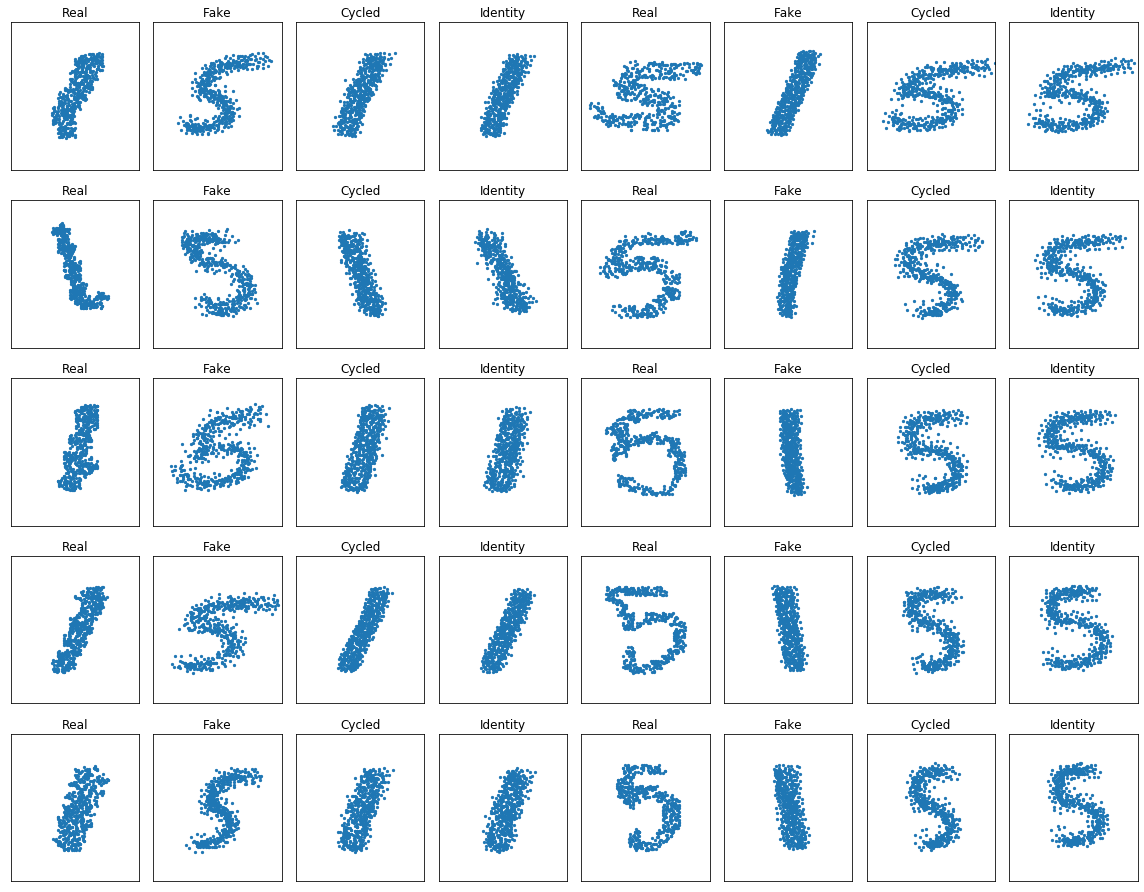

In [21]:
num_samples = 5
x, y = batch

fake_y = generator_g(x)
cycled_x = generator_f(fake_y)
same_x = generator_f(x)

fake_x = generator_f(y)
cycled_y = generator_g(fake_x)
same_y = generator_g(y)

plt.figure(figsize=(16, num_samples*2.5))

for k, (real, fake, cycled, same) in enumerate([(x, fake_y, cycled_x, same_x), (y, fake_x, cycled_y, same_y)]):
    for i in range(num_samples):
        labels = ("Real", "Fake", "Cycled", "Identity")
        digits = (real[i], fake[i], cycled[i], same[i])
        for j, (label, digit) in enumerate(zip(labels, digits)):
            plt.subplot(num_samples, 8, 8*i + 4*k + j + 1)
            plt.title(f"{label}")
            plt.scatter(*tf.transpose(digit), s=5)
            plt.xlim((-3, 3))
            plt.ylim((-3, 3))
            plt.xticks([])
            plt.yticks([])
plt.tight_layout()
plt.show()

---
## DNA-GAST

This model aims to utilize the GAST framework for sets of high-dimensional elements in the form of pre-trained DNA embeddings.

### Configuration

We first again ensure that the Set Transformers framework is utilizing Keras' multi-head attention mechanism.

In [4]:
sf.config("use_keras_mha", False)

False

In [14]:
KMERS = 3
SEQUENCE_LENGTH = 150
KMER_SEQUENCE_LENGTH = int(SEQUENCE_LENGTH / KMERS)
SUBSAMPLE_SIZE = 1000
DNA_EMBED_DIM = 128

### Pre-trained Embedding Model

This model is a pre-trained embedding model designed for 3-mer 128-dim embeddings

In [15]:
sequence_length = int(SEQUENCE_LENGTH / KMERS)
num_tokens = 5**KMERS
embed_dim = 32
latent_dim = 128
num_heads = 8
enc_stack = 1
dec_stack = 1

with strategy.scope():
    # Encoder
    y = x = keras.layers.Input((sequence_length,))
    y = keras.layers.Embedding(input_dim=num_tokens, output_dim=embed_dim)(y)
    y = common.FixedPositionEmbedding(length=sequence_length, embed_dim=embed_dim)(y)
    for _ in range(enc_stack):
        y = common.TransformerBlock(embed_dim, num_heads, ff_dim=embed_dim)(y)
    y = keras.layers.Flatten()(y)
    y = keras.layers.Dense(latent_dim)(y)
    encoder = keras.Model(x, y)

    # Decoder
    y = x = keras.layers.Input((encoder.output.shape[1:]))
    y = keras.layers.Dense(sequence_length*embed_dim)(y)
    y = keras.layers.Reshape((-1, embed_dim))(y)
    y = embed = common.FixedPositionEmbedding(length=sequence_length, embed_dim=embed_dim)(y)
    for _ in range(dec_stack):
        y = common.TransformerBlock(embed_dim, num_heads, ff_dim=embed_dim)(y)
        y = keras.layers.Add()((embed, y))
    y = keras.layers.Dense(num_tokens, activation="softmax")(y)
    decoder = keras.Model(x, y)

    # Coupled model
    y = x = keras.layers.Input(encoder.input.shape[1:])
    y = encoder(y)
    y = decoder(y)
    embed_model = keras.Model(x, y)
    embed_model.encoder = encoder
    embed_model.decoder = decoder
    embed_model.compile(
        keras.optimizers.Nadam(1e-3),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=[keras.metrics.SparseCategoricalAccuracy()])
    embed_model.load_weights("./models/embedding.h5")

### Model Architecture

In [16]:
NOISE_DIM = 64
EMBED_DIM = 192
LATENT_DIM = EMBED_DIM*4
NUM_HEADS = 12
NUM_ANCHORS = 48
MAX_SET_SIZE = SUBSAMPLE_SIZE

## Generator

In [17]:
with strategy.scope():
    noise = keras.layers.Input((NOISE_DIM,))
    cardinality = keras.layers.Input((1,), dtype=tf.int32)
    
    condition = tfa.layers.SpectralNormalization(keras.layers.Dense(NOISE_DIM))(noise)
    
    y1 = y = common.SampleSet(MAX_SET_SIZE, EMBED_DIM)(cardinality)
    
    # Condition the set
    y1 = common.ConditionedISAB(embed_dim=EMBED_DIM, dim_cond=NOISE_DIM, num_heads=NUM_HEADS, num_anchors=NUM_ANCHORS)((y, condition))
    y = keras.layers.Add()((y1, y))
    y1 = common.ConditionedISAB(embed_dim=EMBED_DIM, dim_cond=NOISE_DIM, num_heads=NUM_HEADS, num_anchors=NUM_ANCHORS)((y, condition))
    y = keras.layers.Add()((y1, y))
    y1 = common.ConditionedISAB(embed_dim=EMBED_DIM, dim_cond=NOISE_DIM, num_heads=NUM_HEADS, num_anchors=NUM_ANCHORS)((y, condition))
    y = keras.layers.Add()((y1, y))
    y = common.ConditionedISAB(embed_dim=EMBED_DIM, dim_cond=NOISE_DIM, num_heads=NUM_HEADS, num_anchors=NUM_ANCHORS)((y, condition))
    
    y = tfa.layers.SpectralNormalization(keras.layers.Dense(DNA_EMBED_DIM, use_bias=False))(y)
    generator = keras.Model((noise, cardinality), y)

### Discriminator

In [20]:
with strategy.scope():
    y = x = keras.layers.Input((None, DNA_EMBED_DIM))
    y1 = y = tfa.layers.SpectralNormalization(keras.layers.Dense(EMBED_DIM))(y)
    enc = []
    for i in range(3):
        y = sf.ISAB(EMBED_DIM, num_heads=NUM_HEADS, num_induce=NUM_ANCHORS)(y)
        y1 = y = keras.layers.Add()((y1, y))
        enc.append(sf.ISE(1, EMBED_DIM, NUM_HEADS)(y))
    y = keras.layers.Concatenate()(enc)
    y = tfa.layers.SpectralNormalization(keras.layers.Dense(1))(y)
    discriminator = keras.Model(x, y)

### Coupled Model

In [21]:
with strategy.scope():
    x1 = keras.layers.Input(generator.input_shape[0][1:])
    x2 = keras.layers.Input(generator.input_shape[1][1:])
    y = generator((x1, x2))
    y = discriminator(y)
    model = keras.Model((x1, x2), y)

In [22]:
model.load_weights("./models/dnagast.h5")